<h1>Jason Olefson Project 2 Part 1 Deep Learning</h1>

<h1>Imports</h1>

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np

<h1>GPU Check</h1>
<h3>IMPORTANT In this project, I used my GPU (NVIDIA RTX 4080) to train my model. Because of this, you may need to configure the first few blocks on this file to run on your device. Thank you.</h3>

In [2]:
# Check for GPU availability
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Check if TensorFlow is using GPU for cuDNN-enabled operations
# print("Is TensorFlow using GPU?: ", tf.test.is_built_with_cuda())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17945631789764304926
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14048821248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14741746757010475823
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used.")
else:
    print("No GPU detected, using CPU.")

GPU is available and being used.


<h1>Data Prep</h1>

In [4]:
# Define data directory path
data_dir = "./Data/"

data_frames = [] # empty list to hold DataFrames

# Combine data into single DataFrame
# loop over each subfolder
for subfolder in os.listdir(data_dir):
    subfolder_path = os.path.join(data_dir, subfolder)
    # check if directory
    if os.path.isdir(subfolder_path):
        # loop over all csv
        for file in os.listdir(subfolder_path):
            if file.endswith(".csv"):
                file_path = os.path.join(subfolder_path, file)
                df = pd.read_csv(file_path, header=None) #read csv
                data_frames.append(df) # add Datafram to list
combined_data = pd.concat(data_frames, ignore_index=True) #combine into single DataFrame
combined_data.columns = ["Baby_ID", "Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation", "Pain_Level"] # rename columns for clarity
combined_data = combined_data[combined_data["Pain_Level"] != "#"] # remove rows with "#" in the 4th column
# Remove the pesky typo
combined_data["Heart_Rate"] = pd.to_numeric(combined_data["Heart_Rate"], errors='coerce')
combined_data["Respiratory_Rate"] = pd.to_numeric(combined_data["Respiratory_Rate"], errors='coerce')
combined_data["Oxygen_Saturation"] = pd.to_numeric(combined_data["Oxygen_Saturation"], errors='coerce')
combined_data.dropna(subset=["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"], inplace=True)
combined_data.head() # for clarity (display first few columns)

,Baby_ID,Heart_Rate,Respiratory_Rate,Oxygen_Saturation,Pain_Level
0,0,142,60,100.0,0
1,1,142,60,100.0,0
2,2,142,60,100.0,0
3,3,142,59,100.0,0
4,4,143,59,100.0,0


<h1>Shuffle/Split Dataset</h1>

In [5]:
combined_data = shuffle(combined_data, random_state=42) # shuffle dataset
train, temp = train_test_split(combined_data, test_size=0.1, random_state=42) # split to training/temp sets (90% training, 10% temp)
validation, test = train_test_split(temp, test_size=0.5, random_state=42) # split temp set into validation/test sets (10% of total each)

# separate features/labels for each set
X_train = train[["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"]]
y_train = train["Pain_Level"]
X_val = validation[["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"]]
y_val = validation["Pain_Level"]
X_test = test[["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"]]
y_test = test["Pain_Level"]

<h1>Normalization</h1>

In [6]:
scaler = StandardScaler()

# Normalization for feature columns
X_train = scaler.fit_transform(train[["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"]])
X_val = scaler.transform(validation[["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"]])
X_test = scaler.transform(test[["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"]])
# Convert normalized arrays back to DataFrames
X_train = pd.DataFrame(X_train, columns=["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"])
X_val = pd.DataFrame(X_val, columns=["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"])
X_test = pd.DataFrame(X_test, columns=["Heart_Rate", "Respiratory_Rate", "Oxygen_Saturation"])
# Label extraction
y_train = train["Pain_Level"].reset_index(drop=True)
y_val = validation["Pain_Level"].reset_index(drop=True)
y_test = test["Pain_Level"].reset_index(drop=True)

X_train.head() # for clarity (display first few columns)

,Heart_Rate,Respiratory_Rate,Oxygen_Saturation
0,-0.008015,1.379319,0.346797
1,0.179711,-0.030464,0.346797
2,0.254802,1.072845,0.272768
3,-0.008015,0.521190,0.346797
4,-0.777694,-1.440248,0.346797


In [7]:
# Feature data: Convert to float32 and reshape to (samples, timesteps, features)
X_train = X_train.values.astype('float32').reshape(-1, 3, 1)
X_val = X_val.values.astype('float32').reshape(-1, 3, 1)
X_test = X_test.values.astype('float32').reshape(-1, 3, 1)

# Label data: Convert to int32 without reshaping further
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')
y_test = y_test.astype('int32')

<h1>Build GRU Model</h1>

In [8]:
# Model Architecture
model = Sequential([
    GRU(16, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(16, return_sequences=True),
    Dropout(0.2),
    GRU(16, return_sequences=True),
    Dropout(0.2),
    GRU(16, return_sequences=False),
    Dropout(0.2),
    Dense(3, activation='softmax') # 3 unit output layer (for 3 classes) / softmax activation
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary() # display summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 16)             912       
                                                                 
 dropout (Dropout)           (None, 3, 16)             0         
                                                                 
 gru_1 (GRU)                 (None, 3, 16)             1632      
                                                                 
 dropout_1 (Dropout)         (None, 3, 16)             0         
                                                                 
 gru_2 (GRU)                 (None, 3, 16)             1632      
                                                                 
 dropout_2 (Dropout)         (None, 3, 16)             0         
                                                                 
 gru_3 (GRU)                 (None, 16)                1

<h1>Training</h1>

In [9]:
# Epochs/Batch size (adjust as needed)
epochs = 50
batch_size = 32

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/50
492/492 [==============================] - 7s 6ms/step - loss: 0.7952 - accuracy: 0.6257 - val_loss: 0.6798 - val_accuracy: 0.7082
Epoch 2/50
492/492 [==============================] - 2s 5ms/step - loss: 0.6861 - accuracy: 0.7129 - val_loss: 0.6379 - val_accuracy: 0.7380
Epoch 3/50
492/492 [==============================] - 3s 5ms/step - loss: 0.6652 - accuracy: 0.7186 - val_loss: 0.6279 - val_accuracy: 0.7288
Epoch 4/50
492/492 [==============================] - 3s 5ms/step - loss: 0.6489 - accuracy: 0.7208 - val_loss: 0.6093 - val_accuracy: 0.7449
Epoch 5/50
492/492 [==============================] - 3s 5ms/step - loss: 0.6371 - accuracy: 0.7287 - val_loss: 0.6123 - val_accuracy: 0.7437
Epoch 6/50
492/492 [==============================] - 3s 5ms/step - loss: 0.6308 - accuracy: 0.7323 - val_loss: 0.6043 - val_accuracy: 0.7494
Epoch 7/50
492/492 [==============================] - 3s 5ms/step - loss: 0.6280 - accuracy: 0.7313 - val_loss: 0.5909 - val_accuracy: 0.7483
Epoch 

<h1>Plot Training and Valid Performance</h1>

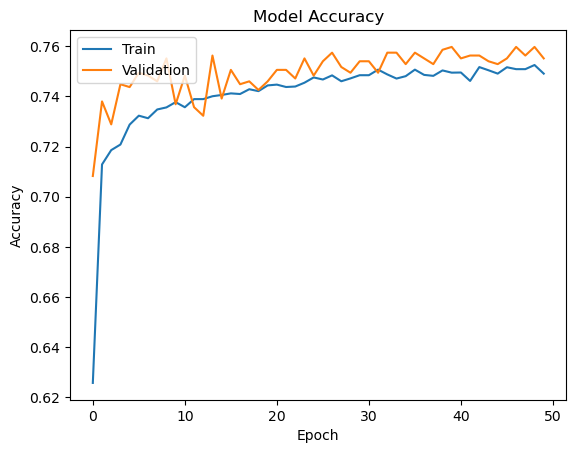

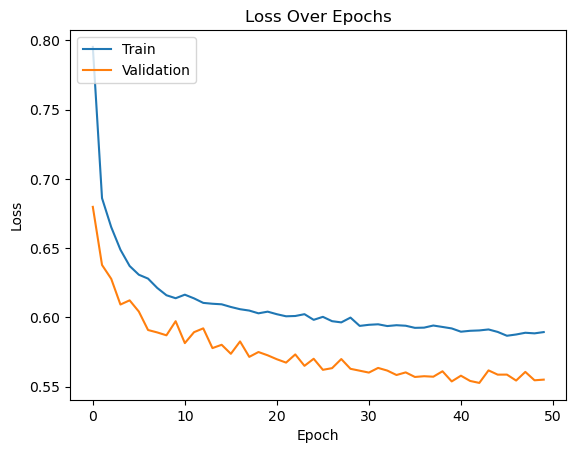

In [10]:
# Training/Validation Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Training/Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h1>Report</h1>